In [ ]:
# Tahap 1: Download dataset via KaggleHub
import os
import kagglehub

print("--- Tahap 1: Download dataset via KaggleHub ---")
path = kagglehub.dataset_download("loki4514/rice-leaf-diseases-detection")
print("Dataset diunduh ke:", path)
print("Isi folder root dataset:", os.listdir(path))

if "rice_leaf_diseases" in os.listdir(path):
    DATA_DIR = os.path.join(path, "rice_leaf_diseases")
else:
    DATA_DIR = path

print("DATA_DIR yang digunakan:", DATA_DIR)
print("Contoh 5 folder / kelas (jika ada):", os.listdir(DATA_DIR)[:5])


C:\Users\azzik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Tahap 1: Download dataset via KaggleHub ---


100%|██████████| 8.03G/8.03G [24:21<00:00, 5.90MB/s]  

Extracting files...


Dataset diunduh ke: C:\Users\azzik\.cache\kagglehub\datasets\loki4514\rice-leaf-diseases-detection\versions\8
Isi folder root dataset: ['Rice_Leaf_AUG', 'Rice_Leaf_Diease']
DATA_DIR yang digunakan: C:\Users\azzik\.cache\kagglehub\datasets\loki4514\rice-leaf-diseases-detection\versions\8
Contoh 5 folder / kelas (jika ada): ['Rice_Leaf_AUG', 'Rice_Leaf_Diease']


In [ ]:
# Tahap 2: Import library dan konfigurasi
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi umum
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TOTAL_EPOCHS = 30
EPOCHS_PHASE_1 = 15
EPOCHS_PHASE_2 = TOTAL_EPOCHS - EPOCHS_PHASE_1

# Cek GPU 
print("GPU devices:", tf.config.list_physical_devices('GPU'))


GPU devices: []


In [3]:
# Tahap 3: Data generator + augmentasi
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())
print(f"Jumlah kelas: {num_classes}")
print("Mapping class_indices:", train_gen.class_indices)


Found 24188 images belonging to 2 classes.
Found 6047 images belonging to 2 classes.
Jumlah kelas: 2
Mapping class_indices: {'Rice_Leaf_AUG': 0, 'Rice_Leaf_Diease': 1}


In [4]:
# Tahap 4: Build model
base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze dulu

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
print("Model dibuat — ringkasan:")
model.summary()


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Model dibuat — ringkasan:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,811,926 (18.36 MB)

 Trainable params: 542,210 (2.07 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [5]:
# Tahap 5: Compile dan callbacks
checkpoint_path = os.path.join(MODEL_DIR, "nasnet_best_model.h5")

callbacks_list = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training fase 1 (head)
history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE_1,
    callbacks=callbacks_list,
    verbose=1
)


C:\Users\azzik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7835 - loss: 0.4702
Epoch 1: val_accuracy improved from None to 0.87944, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 2955s 4s/step - accuracy: 0.8109 - loss: 0.4036 - val_accuracy: 0.8794 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 2/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8405 - loss: 0.3394
Epoch 2: val_accuracy improved from 0.87944 to 0.88457, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.8401 - loss: 0.3344 - val_accuracy: 0.8846 - val_loss: 0.2400 - learning_rate: 0.0010
Epoch 3/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8488 - loss: 0.3212
Epoch 3: val_accuracy improved from 0.88457 to 0.89367, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 2029s 3s/step - accuracy: 0.8497 - loss: 0.3183 - val_accuracy: 0.8937 - val_loss: 0.2236 - learning_rate: 0.0010
Epoch 4/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8461 - loss: 0.3128
Epoch 4: val_accuracy improved from 0.89367 to 0.89714, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 1682s 2s/step - accuracy: 0.8476 - loss: 0.3116 - val_accuracy: 0.8971 - val_loss: 0.2305 - learning_rate: 0.0010
Epoch 5/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8551 - loss: 0.3051
Epoch 5: val_accuracy did not improve from 0.89714
756/756 ━━━━━━━━━━━━━━━━━━━━ 1991s 3s/step - accuracy: 0.8529 - loss: 0.3083 - val_accuracy: 0.8918 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 6/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8566 - loss: 0.2996
Epoch 6: val_accuracy improved from 0.89714 to 0.89995, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 1740s 2s/step - accuracy: 0.8539 - loss: 0.3016 - val_accuracy: 0.9000 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 7/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8567 - loss: 0.3020
Epoch 7: val_accuracy improved from 0.89995 to 0.90590, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 1639s 2s/step - accuracy: 0.8584 - loss: 0.2987 - val_accuracy: 0.9059 - val_loss: 0.2286 - learning_rate: 0.0010
Epoch 8/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8627 - loss: 0.2962
Epoch 8: val_accuracy did not improve from 0.90590
756/756 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.8617 - loss: 0.2931 - val_accuracy: 0.8864 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 9/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8624 - loss: 0.2915
Epoch 9: val_accuracy did not improve from 0.90590

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
756/756 ━━━━━━━━━━━━━━━━━━━━ 1578s 2s/step - accuracy: 0.8601 - loss: 0.2939 - val_accuracy: 0.9004 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 10/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8634 - loss: 0.2863
Epoch 10: val_accuracy improved from 0.90590 to 0.91020, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NA

756/756 ━━━━━━━━━━━━━━━━━━━━ 1577s 2s/step - accuracy: 0.8634 - loss: 0.2835 - val_accuracy: 0.9102 - val_loss: 0.2091 - learning_rate: 2.0000e-04
Epoch 11/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8628 - loss: 0.2784
Epoch 11: val_accuracy improved from 0.91020 to 0.91368, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 1672s 2s/step - accuracy: 0.8642 - loss: 0.2779 - val_accuracy: 0.9137 - val_loss: 0.2080 - learning_rate: 2.0000e-04
Epoch 12/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8685 - loss: 0.2790
Epoch 12: val_accuracy did not improve from 0.91368

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
756/756 ━━━━━━━━━━━━━━━━━━━━ 1739s 2s/step - accuracy: 0.8672 - loss: 0.2799 - val_accuracy: 0.8917 - val_loss: 0.2076 - learning_rate: 2.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 6.


In [ ]:
# Tahap 6: Fine-tuning
base_model.trainable = True

# for layer in base_model.layers[:250]:
#     layer.trainable = False
# for layer in base_model.layers[250:]:
#     layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE_2,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8267 - loss: 0.3702
Epoch 1: val_accuracy improved from 0.91368 to 0.91798, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 4126s 5s/step - accuracy: 0.8489 - loss: 0.3237 - val_accuracy: 0.9180 - val_loss: 0.1857 - learning_rate: 1.0000e-05
Epoch 2/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8768 - loss: 0.2624
Epoch 2: val_accuracy improved from 0.91798 to 0.91847, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 3256s 4s/step - accuracy: 0.8776 - loss: 0.2575 - val_accuracy: 0.9185 - val_loss: 0.1812 - learning_rate: 1.0000e-05
Epoch 3/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8851 - loss: 0.2454
Epoch 3: val_accuracy did not improve from 0.91847
756/756 ━━━━━━━━━━━━━━━━━━━━ 2923s 4s/step - accuracy: 0.8860 - loss: 0.2376 - val_accuracy: 0.9148 - val_loss: 0.1788 - learning_rate: 1.0000e-05
Epoch 4/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8843 - loss: 0.2371
Epoch 4: val_accuracy improved from 0.91847 to 0.91979, saving model to c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


756/756 ━━━━━━━━━━━━━━━━━━━━ 2894s 4s/step - accuracy: 0.8883 - loss: 0.2298 - val_accuracy: 0.9198 - val_loss: 0.1772 - learning_rate: 1.0000e-05
Epoch 5/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8909 - loss: 0.2209
Epoch 5: val_accuracy did not improve from 0.91979
756/756 ━━━━━━━━━━━━━━━━━━━━ 2857s 4s/step - accuracy: 0.8916 - loss: 0.2198 - val_accuracy: 0.9190 - val_loss: 0.1764 - learning_rate: 1.0000e-05
Epoch 6/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8958 - loss: 0.2148
Epoch 6: val_accuracy did not improve from 0.91979
756/756 ━━━━━━━━━━━━━━━━━━━━ 3055s 4s/step - accuracy: 0.8940 - loss: 0.2143 - val_accuracy: 0.9175 - val_loss: 0.1784 - learning_rate: 1.0000e-05
Epoch 7/15
756/756 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8946 - loss: 0.2154
Epoch 7: val_accuracy did not improve from 0.91979
756/756 ━━━━━━━━━━━━━━━━━━━━ 3947s 5s/step - accuracy: 0.8950 - loss: 0.2095 - val_accuracy: 0.9183 - val_loss: 0.1704 - learning_rate: 1.0000e-05
Epoc

Memuat model terbaik dari: c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step

Classification Report:
                  precision    recall  f1-score   support

   Rice_Leaf_AUG       0.98      0.81      0.89      2358
Rice_Leaf_Diease       0.89      0.99      0.94      3689

        accuracy                           0.92      6047
       macro avg       0.93      0.90      0.91      6047
    weighted avg       0.93      0.92      0.92      6047



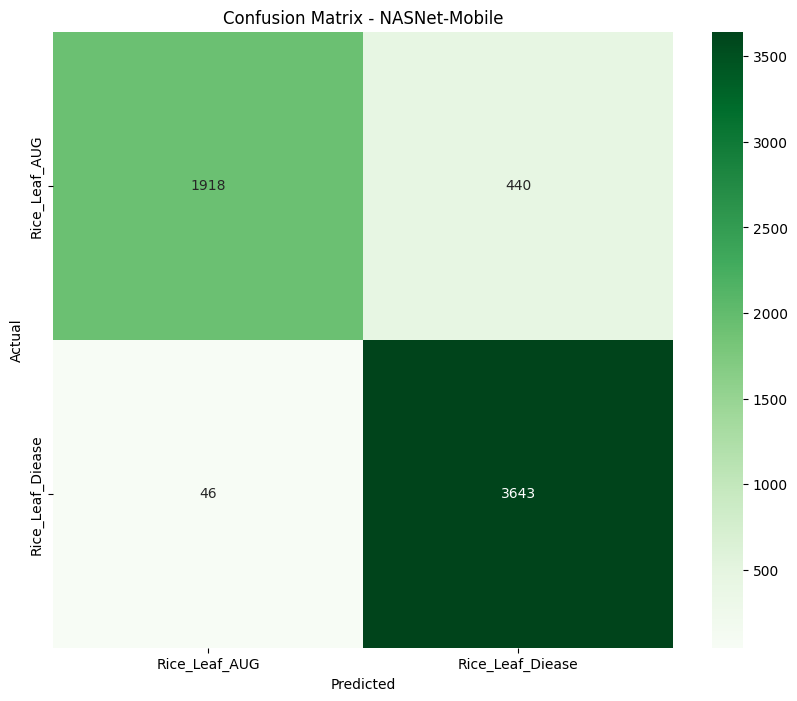

In [7]:
# Tahap 7: Evaluasi
print("Memuat model terbaik dari:", checkpoint_path)
best_model = load_model(checkpoint_path)

# Reset generator validasi sebelum prediksi agar indices sesuai
val_gen.reset()
preds = best_model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - NASNet-Mobile")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Tahap 8: model final
final_path = os.path.join(MODEL_DIR, "nasnet_final.h5")
best_model.save(final_path)
print("Model terbaik disimpan ke:", final_path)


Model terbaik disimpan ke: c:\Users\azzik\Documents\TUGAS SMS7\Metodologi\NASNetMobile\NASNetMobile- Project\models\nasnet_final.h5


✅ Model berhasil dimuat dari: models/nasnet_final.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

=== HASIL PREDIKSI ===
Nama file gambar   : 20231006_165801.jpg
Kelas terdeteksi   : brown_spot
Tingkat kepercayaan: 71.33%


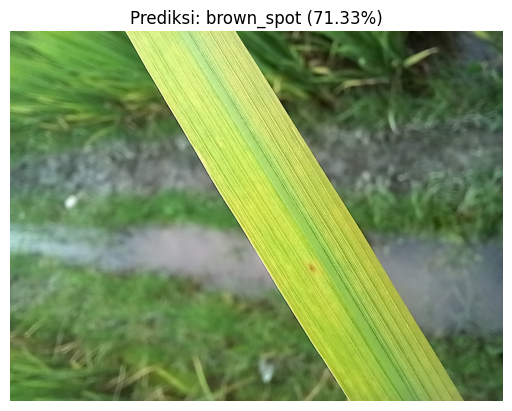

: 

In [ ]:
# === Tahap 9: Uji Coba Model NASNet-Mobile ===
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# === 1. Load model terbaik (format .h5) ===
model_path = "models/nasnet_final.h5"  
model = tf.keras.models.load_model(model_path)
print("✅ Model berhasil dimuat dari:", model_path)

# === 2. Daftar kelas (ubah sesuai dataset kamu) ===
# Misalnya dataset penyakit daun padi:
class_labels = ['bacterial_leaf_blight', 'brown_spot', 'leaf_smut']

# === 3. Masukkan path gambar untuk pengujian ===
img_path = "test_images/20231006_165801.jpg"  

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Gambar tidak ditemukan: {img_path}")

# === 4. Preprocessing gambar ===
img = image.load_img(img_path, target_size=(224, 224))  # default NASNet-Mobile
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalisasi 0-1

# === 5. Prediksi ===
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

# === 6. Tampilkan hasil ===
print("\n=== HASIL PREDIKSI ===")
print(f"Nama file gambar   : {os.path.basename(img_path)}")
print(f"Kelas terdeteksi   : {class_labels[predicted_class]}")
print(f"Tingkat kepercayaan: {confidence * 100:.2f}%")

# === 7. Visualisasi gambar hasil ===
plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]} ({confidence*100:.2f}%)")
plt.show()
